In [1]:
import numpy as np
np.random.seed(0)
import mltools as ml
import matplotlib.pyplot as plt # use matplotlib for plotting with inline plot
%matplotlib inline

### Loading Data

In [2]:
X = np.genfromtxt("C:\\Users\\regin\\Desktop\\CS 178\\Project\\X_train.txt", delimiter = None)
Y = np.genfromtxt("C:\\Users\\regin\\Desktop\\CS 178\\Project\\Y_train.txt", delimiter = None)

Xte = np.genfromtxt("C:\\Users\\regin\\Desktop\\CS 178\\Project\\X_test.txt", delimiter = None)

In [3]:
print(X.shape, Y.shape, Xte.shape)

(200000, 14) (200000,) (200000, 14)


In [4]:
Xtr, Xva, Ytr, Yva = ml.splitData(X, Y) # Default is 80% train & 20% val
Xtr, Ytr = ml.shuffleData(Xtr, Ytr)

In [5]:
print(Xtr.shape, Xva.shape)

(160000, 14) (40000, 14)


In [7]:
#Taking subsample of data so trains faster; Will train on the whole data for Kaggle
Xt, Yt = Xtr[:4000], Ytr[:4000]

Make sure to use predictSoft() function!! For Kaggle, we need to submit probabilites & not just class predicitons

In [10]:
learner = ml.dtree.treeClassify(Xt, Yt, minLeaf = 30, maxDepth = 20)

probs = learner.predictSoft(Xte)

In [11]:
probs

array([[0.17346939, 0.82653061],
       [0.65      , 0.35      ],
       [0.91      , 0.09      ],
       ...,
       [0.86363636, 0.13636364],
       [0.734375  , 0.265625  ],
       [0.56976744, 0.43023256]])

In [12]:
print("{0:>15}: {1:.4f}".format('Train AUC', learner.auc(Xt,Yt)))
print("{0:>15}: {1:.4f}".format('Validation AUC', learner.auc(Xva,Yva)))

      Train AUC: 0.7741
 Validation AUC: 0.6090


In [16]:
learner = ml.dtree.treeClassify()
learner.train(Xt, Yt, maxDepth = 2)
print(learner)

  if x[10] < 239.140000:
    if x[10] < 233.535000:
      Predict [0.46433471 0.53566529]
    else:
      Predict [0.61190818 0.38809182]
  else:
    if x[7] < 3.312850:
      Predict [0.75144928 0.24855072]
    else:
      Predict [0.65255906 0.34744094]



### Linear Classifer

In [19]:
# Scaling the data to avoid numerical data issues (esp for when features are large)
XtrP, params = ml.rescale(Xt)
XteP, _ = ml.rescale(Xte, params)
XvaP, _ = ml.rescale(Xva, params)

print(XtrP.shape, XteP.shape, XvaP.shape)

(4000, 14) (200000, 14) (40000, 14)


In [20]:
# Train model
learner = ml.linearC.linearClassify()
learner.train(XtrP, Yt, initStep = 0.5, stopTol = 1e-6, stopIter = 100)
        # When first debugging, can keep stopTol large & stopIter
        # but may want to tune for Kaggle
probs = learner.predictSoft(XteP)
print(probs[:5])

[[0.5823529  0.4176471 ]
 [0.85750737 0.14249263]
 [0.72632018 0.27367982]
 [0.4984269  0.5015731 ]
 [0.4691194  0.5308806 ]]


In [21]:
print("{0:>15}: {1:.4f}".format('Train AUC', learner.auc(XtrP,Yt)))
print("{0:>15}: {1:.4f}".format('Validation AUC', learner.auc(XvaP,Yva)))

      Train AUC: 0.6119
 Validation AUC: 0.6200


### Neural Network

In [25]:
nn = ml.nnet.nnetClassify()

After constructing classifer, we can define sizes of its layers & initialize values w/ nn.init_weights(self, sizes, init, X, Y)

From method description (see mltools/nnet.py)
    sizes = [Ninput, N1, N2, ..., Noutput], 
        Ninput = # of input features
        Noutput = # classes
    init = {'zeros', 'random'} : initialize to all zeros or random values (breaks symmetry)

Train model using gradient descent --> keep track of surrogate loss (here, MSE loss on output vector, compared to 1-of-K representation of class), as well as 0/1 classification loss (error rate):

In [26]:
nn.init_weights([14,5,3], 'random', Xt, Yt)
nn.train(Xt, Yt, stopTol = 1e-8, stepsize = 0.25, stopIter = 50)

ValueError: layers[-1] must equal the number of classes in Y, or 1 for binary Y

In [27]:
# Need to specify RIGHT number of input & output layer
nn.init_weights([Xt.shape[1], 5, len(np.unique(Yt))], 'random', Xt, Yt)
        # One hidden layer w/ 5 weights
nn.train(Xt, Yt, stopTol = 1e-8, stepsize = 0.25, stopIter = 50) # Really small stopIter so it will stop fast

it 1 : Jsur = 0.47627597374835745, J01 = 0.3375
it 2 : Jsur = 0.454734257745067, J01 = 0.3375
it 4 : Jsur = 0.43878327246468973, J01 = 0.3375
it 8 : Jsur = 0.4395518030470107, J01 = 0.3375
it 16 : Jsur = 0.43785748858290224, J01 = 0.3375
it 32 : Jsur = 0.43796308019416375, J01 = 0.3375


In [28]:
print("{0:>15}: {1:.4f}".format('Train AUC', nn.auc(Xt,Yt)))
print("{0:>15}: {1:.4f}".format('Validation AUC', nn.auc(Xva,Yva)))

      Train AUC: 0.5830
 Validation AUC: 0.5878


One option you can change is the activation function. This is the function that is in the inner layers. By default, the code comes w/ the tanh, but logistic is also coded in & you can specify it.

Also, to avoid numerical overflow issues, you can try using the rescaled features as we did w/ linear classifer.

You can play with shapes of hidden layer(s).

In [30]:
nn.setActivation('logistic')
nn.init_weights([XtrP.shape[1], 20, len(np.unique(Yt))], 'random', XtrP, Yt)
nn.train(XtrP, Yt, stopTol = 1e-8, stepsize = 0.25, stopIter = 100)
print("{0:>15}: {1:.4f}".format('Train AUC', nn.auc(XtrP,Yt)))
print("{0:>15}: {1:.4f}".format('Validation AUC', nn.auc(XvaP,Yva)))

it 1 : Jsur = 0.42623774042808543, J01 = 0.3265
it 2 : Jsur = 0.42137332587258086, J01 = 0.31775
it 4 : Jsur = 0.41970865808644636, J01 = 0.31425
it 8 : Jsur = 0.4191085786294226, J01 = 0.3135
it 16 : Jsur = 0.4189133410877228, J01 = 0.31275
it 32 : Jsur = 0.4189198193324197, J01 = 0.313
it 64 : Jsur = 0.4188654806217776, J01 = 0.3135
      Train AUC: 0.6459
 Validation AUC: 0.6542


### Writing your own activation function

You can also provide a custom activation function. Note that for last layer you will probably always want the sigmoid function, so only change those for the inner layers. 

The function definition is this:
    setActivation(self, method, sig = None, d_sig = None, sig_0 = None, d_sig_0 = None) 
    
You can call it with method = 'custom' & then specify both sig & d_sig (the sig_0 and d_sig_0 ones are the last layer). 

In [33]:
# Here's a dummy activation method (f(x) = x); just make sure using nonlinearity activation function
sig = lambda z: np.atleast_2d(z)
dsig = lambda z: np.atleast_2d(1)

In [34]:
nn = ml.nnet.nnetClassify()
nn.init_weights([Xt.shape[1], Xt.shape[1]*2, len(np.unique(Yt))], 'random', XtrP, Yt)

nn.setActivation('custom', sig, dsig)

nn.train(XtrP, Yt, stopTol = 1e-20, stepsize = 0.25, stopIter = 100)

print("{0:>15}: {1:.4f}".format('Train AUC', nn.auc(XtrP,Yt)))
print("{0:>15}: {1:.4f}".format('Validation AUC', nn.auc(XvaP,Yva)))

it 1 : Jsur = 0.4366100250381344, J01 = 0.33675
it 2 : Jsur = 0.43234981456693744, J01 = 0.336
it 4 : Jsur = 0.4264222651302991, J01 = 0.33225
it 8 : Jsur = 0.4216383877791734, J01 = 0.325
it 16 : Jsur = 0.4190581339163307, J01 = 0.318
it 32 : Jsur = 0.4182963680198954, J01 = 0.317
it 64 : Jsur = 0.4181871728686476, J01 = 0.31675
      Train AUC: 0.6458
 Validation AUC: 0.6546


### Tuning Hyperparameters

We're learned that one way of guessing how well we're doing with different model parameters is to plot the train & val errors as a function of that parameters (eg. k in KNN or degree in linear classifer/regression).

Now it seems like there could be more parameters involved. One example is minLeaf & the maxDepth values in decision tree. 

When it's two parameter, you can simply use heatmaps. The x & y axes represent the parameters, and the "heat" is the validation error as the "third" dimensions

We're going to use dummy function to show that. Assume we have 2 parameters p1 & p2, and prediction accuracy is p1 + p2 (just as ex, you would use real evaluation metric like AUC in real applications)

In [36]:
p1 = np.arange(5)
p2 = np.arange(5)

In [41]:
acc = np.zeros([p1.shape[0], p2.shape[0]])
for i in range(p1.shape[0]):
    for j in range(p2.shape[0]):
        acc[i][j] = p1[i] + p2[j]
        # here you would do your prediction & scoring
        # store scoring in acc[i][j]

In [42]:
acc

array([[0., 1., 2., 3., 4.],
       [1., 2., 3., 4., 5.],
       [2., 3., 4., 5., 6.],
       [3., 4., 5., 6., 7.],
       [4., 5., 6., 7., 8.]])

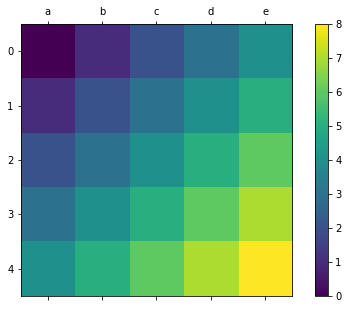

In [43]:
f, ax = plt.subplots(1, 1, figsize = (8,5))

heatmap = ax.matshow(acc)
f.colorbar(heatmap)

ax.set_xticks(p1)
ax.set_xticklabels(['a', 'b', 'c', 'd', 'e'])

ax.set_yticks(p2)
ax.set_yticklabels(['%d' % p for p in p2])

plt.show()

### Submitting Predictions

Let's assume that last classifer we ran was best one (after we ussed all that we know to verify it is best including plot from previous block) Now let's run test data & create file to be submitted.

Each line in file is data point ID & probability of P(Y=1). There's also header line. Here's how you can create it simply from prob matrix.

In [44]:
probs

array([[0.5823529 , 0.4176471 ],
       [0.85750737, 0.14249263],
       [0.72632018, 0.27367982],
       ...,
       [0.66034152, 0.33965848],
       [0.56398116, 0.43601884],
       [0.56502193, 0.43497807]])

In [47]:
# Create data for submission by taking P(Y=1) column from probs and just add a running index as the first column.
Y_sub = np.vstack([np.arange(Xte.shape[0]), probs[:,1]]).T

#Specify header (ID, Prob1) and specify comments as '' so header won't be commented out with the # sign
np.savetxt("C:\\Users\\regin\\Desktop\\CS 178\\Project\\Y_random.txt", Y_sub, '%d, %.5f', header = 'ID,Prob1', comments = '', delimiter = ',')
